<a href="https://colab.research.google.com/github/Dewak20/Dibimbing/blob/main/Dewa_Krishnadana_A_B_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Load Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.power import TTestPower, TTestIndPower, GofChisquarePower
from statsmodels.stats.proportion import proportions_chisquare
from statsmodels.stats.weightstats import ttest_ind
import statsmodels.api as sm

import scipy.stats

# Load Dataset

In [2]:
raw_data = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/marketing_campaign_experiment/marketing-clean.csv")

In [3]:
raw_data.head(10)

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained,conversion
0,a100000040,1/1/18,House Ads,personalization,True,English,English,19-24 years,1/1/18,1/18/18,House Ads,False,1
1,a100000041,1/1/18,House Ads,personalization,True,Arabic,Arabic,24-30 years,1/1/18,2/22/18,House Ads,False,1
2,a100000042,1/1/18,House Ads,personalization,True,English,English,0-18 years,1/1/18,3/9/18,House Ads,False,1
3,a100000043,1/1/18,House Ads,personalization,True,English,English,19-24 years,1/1/18,2/18/18,House Ads,False,1
4,a100000044,1/1/18,House Ads,personalization,True,Arabic,Arabic,24-30 years,1/1/18,3/3/18,House Ads,False,1
5,a100000045,1/2/18,House Ads,personalization,True,English,English,0-18 years,1/2/18,2/4/18,House Ads,False,1
6,a100000046,1/2/18,House Ads,personalization,True,English,English,19-24 years,1/2/18,1/9/18,House Ads,False,1
7,a100000047,1/2/18,House Ads,personalization,True,English,English,24-30 years,1/2/18,2/4/18,House Ads,False,1
8,a100000048,1/2/18,House Ads,personalization,True,German,German,0-18 years,1/2/18,1/21/18,House Ads,False,1
9,a100000059,1/2/18,House Ads,personalization,True,English,English,19-24 years,1/2/18,2/19/18,House Ads,False,1


# A/B Testing

## Data Inspection and Exploration


Check null values inside data

In [4]:
raw_data.isna().sum()

user_id                0
date_served            0
marketing_channel      0
variant                0
converted              0
language_displayed     0
language_preferred     0
age_group              0
date_subscribed        0
date_canceled          0
subscribing_channel    0
is_retained            0
conversion             0
dtype: int64

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              577 non-null    object
 1   date_served          577 non-null    object
 2   marketing_channel    577 non-null    object
 3   variant              577 non-null    object
 4   converted            577 non-null    bool  
 5   language_displayed   577 non-null    object
 6   language_preferred   577 non-null    object
 7   age_group            577 non-null    object
 8   date_subscribed      577 non-null    object
 9   date_canceled        577 non-null    object
 10  subscribing_channel  577 non-null    object
 11  is_retained          577 non-null    bool  
 12  conversion           577 non-null    int64 
dtypes: bool(2), int64(1), object(10)
memory usage: 50.8+ KB


Check number of sample of each variant

**Jumlah user per marketing channel**


In [6]:
df1 = raw_data.groupby('marketing_channel')['user_id'].count().reset_index()

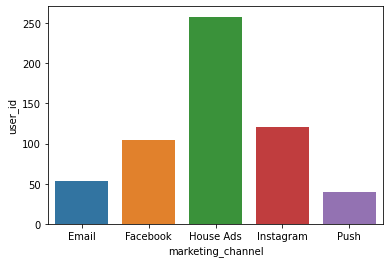

In [7]:
ax = sns.barplot(x='marketing_channel', y='user_id', data=df1,
                 errwidth=0)

**Jumlah user per variant**


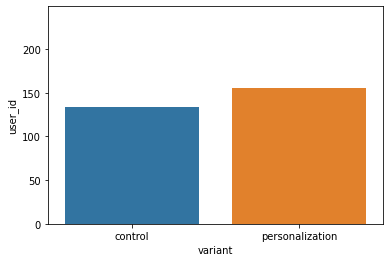

In [8]:
df2 = raw_data.groupby(['converted','variant'])['user_id'].count().reset_index()
ax = sns.barplot(x='variant', y='user_id', data=df2,
                 errwidth=0)

**Jumlah user converted per variant**

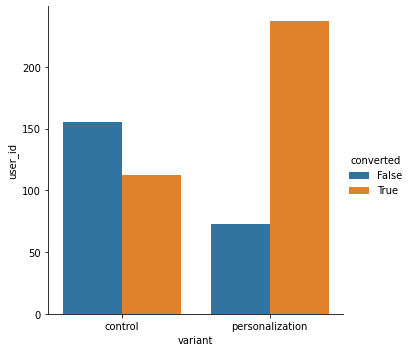

In [9]:
sns.catplot(data=df2, x="variant", y="user_id", hue="converted", kind="bar")

**Jumlah user converted per variant dari waktu ke waktu**

In [10]:
df3 = raw_data.groupby(['converted','date_served','variant'])['user_id'].count().reset_index()

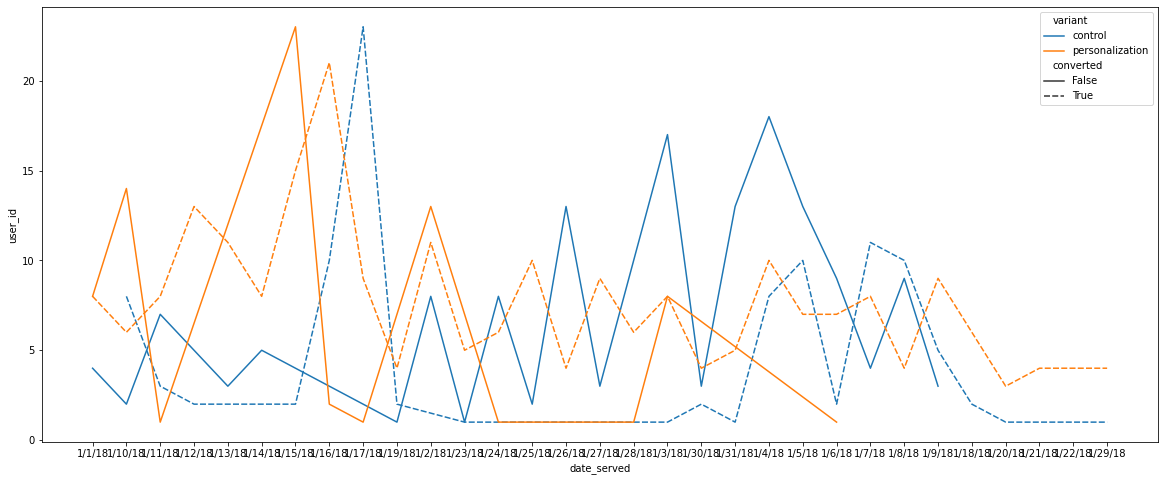

In [11]:
plt.figure(figsize=(20,8))
sns.lineplot(
    data=df3, x="date_served", y="user_id", hue="variant", style="converted",
)

**Jumlah user converted per age group**

In [12]:
df4 = raw_data.groupby(['converted','age_group'])['user_id'].count().reset_index()

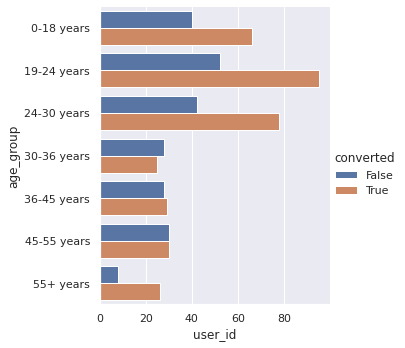

In [13]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.catplot(data=df4, x="user_id", y="age_group", hue="converted", kind="bar")

# Using Linear Models

## Using Logistic Regression for Binary Data


We can use logistic regression when the value to compare is categorical.

In [ ]:
# select variant and converted columns
data_for_model = raw_data[['variant', 'converted']].copy()
# create dummy variables and remove first category ('variant_A')
data_for_model = pd.get_dummies(data_for_model, drop_first = True)
# add constant
data_for_model = sm.add_constant(data_for_model)

In [20]:
# check the first 5 rows
data_for_model

,const,converted,variant_personalization
0,1.0,True,1
1,1.0,True,1
2,1.0,True,1
3,1.0,True,1
4,1.0,True,1
...,...,...,...
572,1.0,True,0
573,1.0,True,0
574,1.0,True,0
575,1.0,True,0


In [21]:
# define and fit logistic regression model
log_reg = sm.Logit(data_for_model['converted'], data_for_model[['variant_personalization','const']]).fit()

Optimization terminated successfully.
         Current function value: 0.607966
         Iterations 5


In [22]:
# check model summary
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:                  577
Model:                          Logit   Df Residuals:                      575
Method:                           MLE   Df Model:                            1
Date:                Sat, 01 Oct 2022   Pseudo R-squ.:                 0.09393
Time:                        11:42:58   Log-Likelihood:                -350.80
converged:                       True   LL-Null:                       -387.16
Covariance Type:            nonrobust   LLR p-value:                 1.482e-17
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
variant_personalization     1.5025      0.182      8.234      0.000       1.145       1.860
const                      -0.3249      0.124     -2.620      0.009      -0.568      -0.082
===========================================================================================
"""

**Interpretation**

- We can observe uplift of variant personalization around 150.25%
- Based on p-value = 0.000 < alpha = 0.05, hence there is strong statistical significance in test results. Then, we should reject null hypothesis and proceed to launch variant personalization for all users
